## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt
%matplotlib inline
import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser


/raid1/stephen/tacotron2-nvidia/plotting_utils.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/mo/anaconda2/envs/tacotron2-nvidia/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mo/anaconda2/envs/tacotron2-nvidia/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mo/anaconda2/envs/tacotron2-nvidia/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mo/anaconda2/envs/tacotron2-nvidia/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mo/anaconda2/envs/tacotron2-nvidia/lib/py

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [4]:
hparams = create_hparams()
hparams.sampling_rate = 22050

#### Load model from checkpoint

In [5]:
checkpoint_path = "model/tacotron2_statedict.pt"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.eval()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [6]:
waveglow_path = 'model/waveglow_old.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda()
denoiser = Denoiser(waveglow)

/home/mo/anaconda2/envs/tacotron2-nvidia/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'glow_old.WaveGlow' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/mo/anaconda2/envs/tacotron2-nvidia/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/mo/anaconda2/envs/tacotron2-nvidia/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can 

#### Decode text input and plot results

In [8]:
type(waveglow)

glow_old.WaveGlow

Warning! Reached max decoder steps


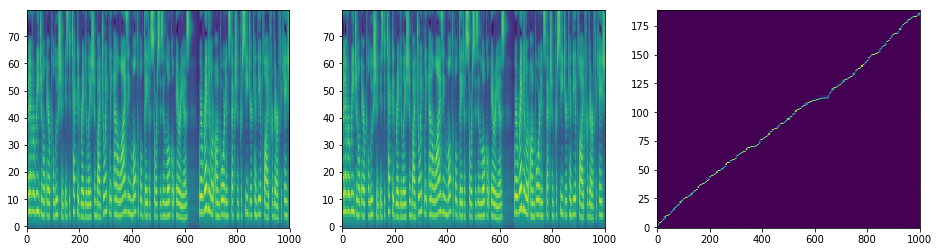

In [21]:
text = "Whenever regional air pollution is detected regulation by jointly analyzing multiple data sources in local areas, where regular onboard inspection procedure can be applied for verification."
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
# ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

In [24]:
from audio import load_wav, save_wav
import librosa

In [26]:
librosa.output.write_wav('tmp.wav', audio_denoised.cpu().numpy().T, 22050)

In [18]:
audio_denoised.cpu().data.numpy()

256000